# Problem Statement
A home electronics company, which manufactures state of the art smart televisions, want to develop a cool feature in the smart-TV that can recognise five different gestures. Gestures will be performed by the users. The feature will help users to control the TV without using a remote. The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

# Objective
As a data scientist at the company, we need to build a model that can correctly
predict the 5 gestures.

# Understanding the Dataset
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Few things to note:  

1. all images in a particular video subfolder have the same dimensions
2. different videos may have different dimensions
3. Specifically, videos have two types of dimensions - either 360x360 or 120x160


Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.



In [1]:
project_data_dir = '/datasets/Project_data/'
train_data_dir = '/datasets/Project_data/train/'
val_data_dir = '/datasets/Project_data/val/'
models_dir = '/home/models/'

# Importing required libraries

In [2]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import random as rn
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, MobileNetV2
from keras.layers import Conv3D, Dense, MaxPooling3D, MaxPooling2D,BatchNormalization, GRU, Flatten, Dropout, Reshape, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")


In [92]:
# Set seeds for reproducibility
rn.seed(30)
np.random.seed(30)
tf.random.set_seed(30)

In [93]:
train_folder_list = np.random.permutation(open(project_data_dir+'train.csv').readlines())
val_folder_list = np.random.permutation(open(project_data_dir+'val.csv').readlines())

In [94]:
num_train_sequences = len(train_folder_list)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_folder_list)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


# Generator
We are providing a generator function.This type of function is very useful in machine learning for handling large datasets that might not fit into your computer's memory all at once. Instead of loading the entire dataset, a generator loads and processes data in smaller chunks called "batches".



### Utility functions

In [95]:
# Image Normalisation
def normalise_image(image):
    normalised_image = (image - np.mean(image)) / np.std(image)
    return normalised_image

In [96]:
def crop_image(img):
    width, height = img.size
    min_dim = min(height, width)
    if width == height:
        min_dim = 250
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = (width + min_dim) // 2
    bottom = (height + min_dim) // 2
    cropped_img = img.crop((left, top, right, bottom))
    return cropped_img

In [97]:
def get_current_batch_data(source_path, t, batch, img_idx, img_size, batch_size, remaining_seq=0):
    seq_len = remaining_seq if remaining_seq else batch_size
    batch_data = np.zeros((batch_size,len(img_idx),img_size[0],img_size[1],3))
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(seq_len): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            filename = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
            img = Image.open(filename)
            img = crop_image(img)
            img = img.resize(img_size, resample = Image.BILINEAR)
            narray = np.asarray(img).astype(np.float32)
            batch_data[folder,idx,:,:,0] = normalise_image(narray[:, :, 0])
            batch_data[folder,idx,:,:,1] = normalise_image(narray[:, :, 1])
            batch_data[folder,idx,:,:,2] = normalise_image(narray[:, :, 2])
                    
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [98]:
def generator(source_path, folder_list, img_idx=[], batch_size=100, img_size=(120,120)):
    '''
    source_path image location
    folder_list folders having information about videos
    img_idx    #frames to use from each video
    batch_size number of videos processed at a time
    img_size a tuple having width and height to resige the image
    '''
    print('Source path = ', source_path, '; batch size =', batch_size)
    if len(img_idx) == 0:
        img_idx = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list) #used to shuffle the order of the videos
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels = get_current_batch_data(source_path, t, batch, img_idx, img_size, batch_size)
            yield batch_data, batch_labels 
        # Handle remaining data points that are left after full batches
        remaining_seq = len(folder_list) % batch_size
        if remaining_seq > 0:
            batch_data, batch_labels = get_current_batch_data(source_path, t, batch, img_idx, img_size, batch_size, remaining_seq)
            yield batch_data, batch_labels



### Validating the Generator

In [10]:
# check complete batch shape
sample_generator = generator(train_data_dir, train_folder_list, batch_size=32)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_data_dir, val_folder_list, batch_size=32)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /datasets/Project_data/train/ ; batch size = 32
(32, 20, 120, 120, 3)
Source path =  /datasets/Project_data/val/ ; batch size = 32
(32, 20, 120, 120, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


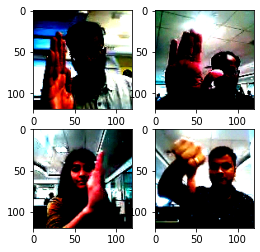

In [11]:
fig, ax = plt.subplots(2,2, figsize=(4,4))
ax[0,0].imshow(sample_batch_data[16,10,:,:,:])
ax[0,1].imshow(sample_batch_data[25,10,:,:,:])

ax[1,0].imshow(sample_val_batch_data[16,10,:,:,:])
ax[1,1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

# Model Creation

### model utilities

In [12]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())

    # fig, ax = plt.subplots(1,2, figsize=(16,8))

    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [13]:
def model_callbacks(model_init):
    curr_dt_time = datetime.datetime.now()
    model_name = models_dir + model_init + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.makedirs(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

In [14]:
def train_model(model_init, model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=100, num_epochs=25):
    """
    Trains a given model.

    Args:
        model: model to train.
        train_ds: The training dataset.
        val_ds: The validation dataset.
        epochs: The number of epochs to train for.

    Returns:
        The training history.
    """

    # defining callbacks
    callbacks_list = model_callbacks(model_init)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
          callbacks=callbacks_list, validation_data=val_generator,
          validation_steps=validation_steps,initial_epoch=0)

    return history


In [15]:
no_classes = 5

### Experiment 1: 3 Conv3D layes 32,64,128 and 1 Dense layers 
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 100
- epochs: 20


In [16]:
train_generator = generator(train_data_dir, train_folder_list)
val_generator = generator(val_data_dir, val_folder_list)

In [17]:
model = Sequential()
sample_shape = (20, 120, 120, 3)
no_classes = 5
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same',))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 5, 30, 30, 64)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 5, 30, 30, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 3, 15, 15, 128)  

2025-04-01 19:25:44.733786: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-04-01 19:25:44.733856: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21985 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:61:00.0, compute capability: 8.6


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [19]:
history = train_model('Model1', model, train_generator, val_generator, num_train_sequences, num_val_sequences, num_epochs=20)

Source path =  /datasets/Project_data/train/ ; batch size = 100
Epoch 1/20


2025-04-01 19:25:59.802817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-04-01 19:26:02.619609: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - ETA: 0s - loss: 6.1698 - categorical_accuracy: 0.1757Source path =  /datasets/Project_data/val/ ; batch size = 100

Epoch 00001: val_loss improved from inf to 1.60908, saving model to /home/models/Model1_2025-04-0119_25_55.094656/model-00001-6.16984-0.17571-1.60908-0.23000.h5
7/7 [==============================] - 32s 4s/step - loss: 6.1698 - categorical_accuracy: 0.1757 - val_loss: 1.6091 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.5199 - categorical_accuracy: 0.1857
Epoch 00002: val_loss improved from 1.60908 to 1.58442, saving model to /home/models/Model1_2025-04-0119_25_55.094656/model-00002-1.51989-0.18571-1.58442-0.32000.h5
7/7 [==============================] - 27s 4s/step - loss: 1.5199 - categorical_accuracy: 0.1857 - val_loss: 1.5844 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.4742 - categorical_

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


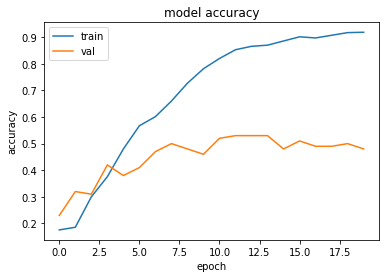

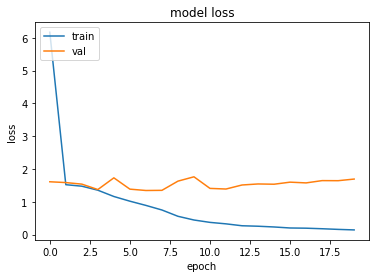

In [20]:
plot_loss_accuracy(history)

### Experiment 1 Observations:
- Difference between val and train accuracy is high. Val loss is also high. Model clearly overfitting.

### Experiment 2: Adding Dropout layers to previous model
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 100
- epochs: 20

In [21]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Dropout(0.25))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Dropout(0.25))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same',))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.25))
model.add(Dense(no_classes, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 60, 60, 32)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 5, 30, 30, 64)    0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 30, 30, 64)    

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [23]:
history = train_model('Model2', model, train_generator, val_generator, num_train_sequences, num_val_sequences, num_epochs=20)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 8.4520 - categorical_accuracy: 0.1871
Epoch 00001: val_loss improved from inf to 1.60942, saving model to /home/models/Model2_2025-04-0119_39_05.693151/model-00001-8.45202-0.18714-1.60942-0.23000.h5
7/7 [==============================] - 29s 5s/step - loss: 8.4520 - categorical_accuracy: 0.1871 - val_loss: 1.6094 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.5241 - categorical_accuracy: 0.1757
Epoch 00002: val_loss improved from 1.60942 to 1.60876, saving model to /home/models/Model2_2025-04-0119_39_05.693151/model-00002-1.52405-0.17571-1.60876-0.23000.h5
7/7 [==============================] - 28s 5s/step - loss: 1.5241 - categorical_accuracy: 0.1757 - val_loss: 1.6088 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.5242 - categorical_accuracy: 0.2057
Epoch 00003: val_loss improved fro

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


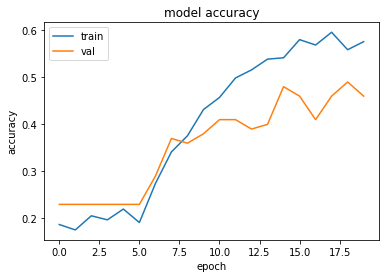

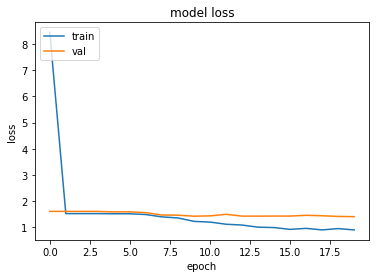

In [24]:
plot_loss_accuracy(history)

### Experiment 2 Observations
Difference between train and val accuracy has been reduced. But, accuracy is reduced.
We will use BatchNormalization to optimize the training and reduce the number of Dropouts.

### Experiment 3 :
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 100
- epochs: 25


In [27]:
model = Sequential()
sample_shape = (20, 120, 120, 3)
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 batch_normalization_4 (Batc  (None, 20, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 batch_normalization_5 (Batc  (None, 10, 60, 60, 64)   256       
 hNormalization)                                                 
                                                      

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [29]:
history = train_model('Model3', model, train_generator, val_generator, num_train_sequences, num_val_sequences)

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 15.4877 - categorical_accuracy: 0.2029
Epoch 00001: val_loss improved from inf to 40.88753, saving model to /home/models/Model3_2025-04-0119_52_49.116150/model-00001-15.48771-0.20286-40.88753-0.24000.h5
7/7 [==============================] - 28s 4s/step - loss: 15.4877 - categorical_accuracy: 0.2029 - val_loss: 40.8875 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 4.6990 - categorical_accuracy: 0.3029
Epoch 00002: val_loss improved from 40.88753 to 39.42966, saving model to /home/models/Model3_2025-04-0119_52_49.116150/model-00002-4.69900-0.30286-39.42966-0.18000.h5
7/7 [==============================] - 27s 4s/step - loss: 4.6990 - categorical_accuracy: 0.3029 - val_loss: 39.4297 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 2.9047 - categorical_accuracy: 0.3429
Epoch 00003: val_loss im

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


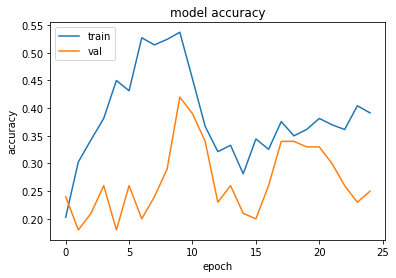

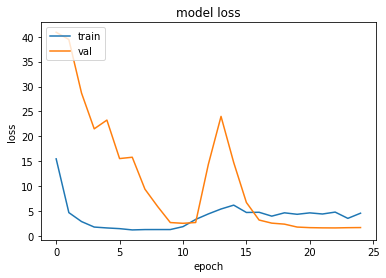

In [30]:
plot_loss_accuracy(history)

### Experiment 3 Observations
val and train accuracy both reduced. val loss is also high. Model is performing poorly.

### Experiment 4 Conv3d with Reduced dropouts
- frames per video: 30
- frame (image) size: 120 * 120
- batch size: 32 (got error wth batch size 100)
- epochs: 25

ResourceExhaustedError:  OOM when allocating tensor with shape[100,32,30,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_7/max_pooling3d_14/MaxPool3D

In [35]:
img_idx_list = [i for i in range(30)]
train_generator = generator(train_data_dir, train_folder_list, img_idx_list, batch_size=50)
val_generator = generator(val_data_dir, val_folder_list, img_idx_list, batch_size=50)

In [36]:
sample_shape = (30, 120, 120, 3)
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same',))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 30, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 15, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 15, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 8, 30, 30, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 8, 30, 30, 128)    221312    
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 4, 15, 15, 128)  

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [38]:
history = train_model('Model4', model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=50)

Source path =  /datasets/Project_data/train/ ; batch size = 50
Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 4.3951 - categorical_accuracy: 0.2271Source path =  /datasets/Project_data/val/ ; batch size = 50

Epoch 00001: val_loss improved from inf to 1.60600, saving model to /home/models/Model4_2025-04-0120_09_51.101639/model-00001-4.39508-0.22714-1.60600-0.17000.h5
14/14 [==============================] - 45s 3s/step - loss: 4.3951 - categorical_accuracy: 0.2271 - val_loss: 1.6060 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 1.5000 - categorical_accuracy: 0.2829
Epoch 00002: val_loss improved from 1.60600 to 1.56711, saving model to /home/models/Model4_2025-04-0120_09_51.101639/model-00002-1.50004-0.28286-1.56711-0.37000.h5
14/14 [==============================] - 40s 3s/step - loss: 1.5000 - categorical_accuracy: 0.2829 - val_loss: 1.5671 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


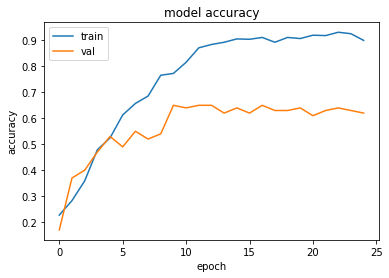

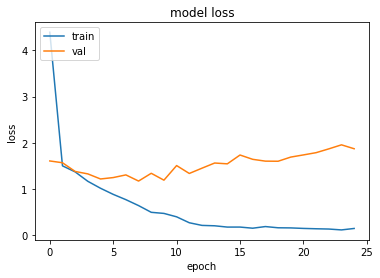

In [39]:
plot_loss_accuracy(history)

### Experiment 4 Observations
val and train accuracy has improved
val loss is still high
model seems to be overfitting

### Experiment 5: Conv 3D with BatchNormalization and Dropouts 

In [40]:
sample_shape = (30, 120, 120, 3)
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same',))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same',))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 32)  2624      
                                                                 
 batch_normalization_8 (Batc  (None, 30, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 64)    55360     
                                                                 
 batch_normalization_9 (Batc  (None, 15, 60, 60, 64)   256       
 hNormalization)                                                 
                                                      

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [42]:
history = train_model('Model5', model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=50)

Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 28.9794 - categorical_accuracy: 0.2086
Epoch 00001: val_loss improved from inf to 1.64617, saving model to /home/models/Model5_2025-04-0120_29_28.985169/model-00001-28.97938-0.20857-1.64617-0.10000.h5
14/14 [==============================] - 41s 3s/step - loss: 28.9794 - categorical_accuracy: 0.2086 - val_loss: 1.6462 - val_categorical_accuracy: 0.1000 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 3.7026 - categorical_accuracy: 0.2314
Epoch 00002: val_loss did not improve from 1.64617
14/14 [==============================] - 38s 3s/step - loss: 3.7026 - categorical_accuracy: 0.2314 - val_loss: 2.3683 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 2.1464 - categorical_accuracy: 0.2729
Epoch 00003: val_loss did not improve from 1.64617
14/14 [==============================] - 39s 3s/step - loss: 2.1464 - categorical_ac

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


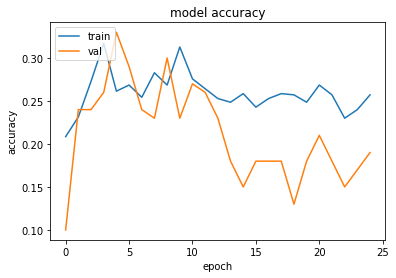

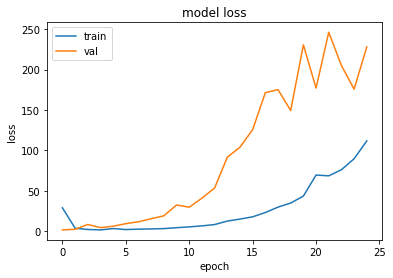

In [43]:
plot_loss_accuracy(history)

### Experiment 5 Observations
It is even performing poorly than previous ones.


### Experiment 6 Adding one more layer and removing BatchNormalization
- frames per video: 20
- frame (image) size: 120 * 120
- batch size: 50 (OOM error with batch size 100)
- epochs: 25

ResourceExhaustedError:  OOM when allocating tensor with shape[100,32,20,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [55]:
train_generator = generator(train_data_dir, train_folder_list, batch_size=50)
val_generator = generator(val_data_dir, val_folder_list, batch_size=50)

In [56]:
model = Sequential()
sample_shape = (20, 120, 120, 3)
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_35 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_35 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_36 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 5, 30, 30, 128)    221312    
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 3, 15, 15, 128) 

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [58]:
history = train_model('Model6', model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=50)

Source path =  /datasets/Project_data/train/ ; batch size = 50
Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 1.7942 - categorical_accuracy: 0.2129Source path =  /datasets/Project_data/val/ ; batch size = 50

Epoch 00001: val_loss improved from inf to 1.59801, saving model to /home/models/Model6_2025-04-0120_52_06.246458/model-00001-1.79417-0.21286-1.59801-0.23000.h5
14/14 [==============================] - 28s 2s/step - loss: 1.7942 - categorical_accuracy: 0.2129 - val_loss: 1.5980 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 1.5106 - categorical_accuracy: 0.2757
Epoch 00002: val_loss did not improve from 1.59801
14/14 [==============================] - 26s 2s/step - loss: 1.5106 - categorical_accuracy: 0.2757 - val_loss: 1.6543 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 1.4805 - categorical_accuracy: 0.3143
Epoch 00003: v

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


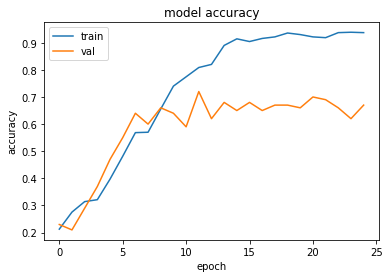

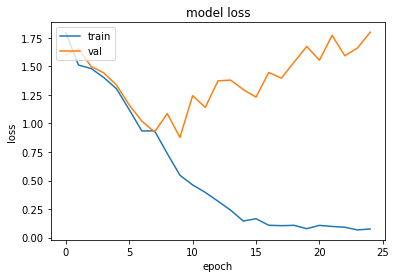

In [59]:
plot_loss_accuracy(history)

### Experiment 6 Observation
- Model is still overfitting
- val loss is too high

### Experiment 7 

In [99]:
train_generator = generator(train_data_dir, train_folder_list, batch_size=50)
val_generator = generator(val_data_dir, val_folder_list, batch_size=50)

In [100]:
model = Sequential()
sample_shape = (20, 120, 120, 3)
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 10, 60, 60, 32)    0         
                                                                 
 conv3d_73 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_69 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 5, 30, 30, 64)   

In [101]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [102]:
history = train_model('Model7', model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=50, num_epochs=30)

Source path =  /datasets/Project_data/train/ ; batch size = 50
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.7292 - categorical_accuracy: 0.2071Source path =  /datasets/Project_data/val/ ; batch size = 50

Epoch 00001: val_loss improved from inf to 1.60883, saving model to /home/models/Model7_2025-04-0121_47_24.053002/model-00001-1.72922-0.20714-1.60883-0.22000.h5
14/14 [==============================] - 27s 2s/step - loss: 1.7292 - categorical_accuracy: 0.2071 - val_loss: 1.6088 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5237 - categorical_accuracy: 0.2200
Epoch 00002: val_loss improved from 1.60883 to 1.60674, saving model to /home/models/Model7_2025-04-0121_47_24.053002/model-00002-1.52371-0.22000-1.60674-0.30000.h5
14/14 [==============================] - 26s 2s/step - loss: 1.5237 - categorical_accuracy: 0.2200 - val_loss: 1.6067 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


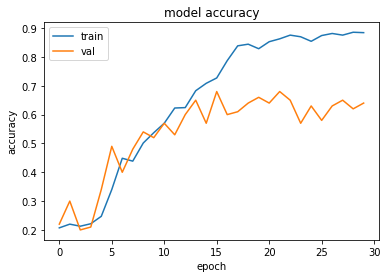

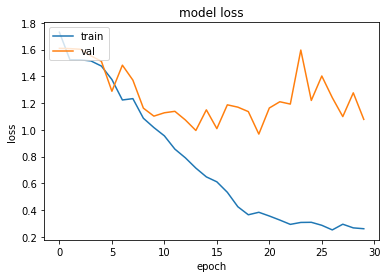

In [103]:
plot_loss_accuracy(history)

### Experiment 7 Observations
Model still overfits. Data augmentation techniques could have been useful.

### Experiemt 8 CNN Transfer Learning (Resnet50) + GRU

In [104]:
train_generator = generator(train_data_dir, train_folder_list, batch_size=32, img_size=(224,224))
val_generator = generator(val_data_dir, val_folder_list, batch_size=32, img_size=(224,224))

In [105]:
resnet_model = ResNet50(include_top=False)
model = Sequential()
model.add(TimeDistributed(resnet_model, input_shape=(20, 224, 224, 3))) 
model.add(Reshape((-1,2048)))
model.add(GRU(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
model.layers[0].trainable = False

model.summary()

94781440/94765736 [==============================] - 7s 0us/step
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 7, 7, 2048)   23587712  
 ibuted)                                                         
                                                                 
 reshape (Reshape)           (None, 980, 2048)         0         
                                                                 
 gru (GRU)                   (None, 128)               836352    
                                                                 
 dense_55 (Dense)            (None, 128)               16512     
                                                                 
 dense_56 (Dense)            (None, 5)                 645       
                                                                 
Total params: 24,441,221
Trainable params: 853,509
Non

In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [107]:
history = train_model('Model8', model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=32, num_epochs=20)

Source path =  /datasets/Project_data/train/ ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5929 - categorical_accuracy: 0.2619Source path =  /datasets/Project_data/val/ ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.20397, saving model to /home/models/Model8_2025-04-0122_02_31.757256/model-00001-1.59291-0.26190-1.20397-0.24219.h5
21/21 [==============================] - 49s 2s/step - loss: 1.5929 - categorical_accuracy: 0.2619 - val_loss: 1.2040 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3498 - categorical_accuracy: 0.4167
Epoch 00002: val_loss did not improve from 1.20397
21/21 [==============================] - 45s 2s/step - loss: 1.3498 - categorical_accuracy: 0.4167 - val_loss: 1.2478 - val_categorical_accuracy: 0.2578 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.2283 - categorical_accuracy: 0.4643
Epoch 00003: v

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


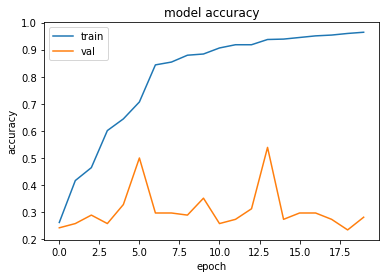

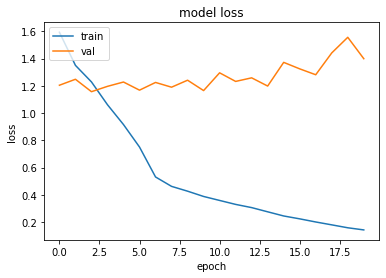

In [108]:
plot_loss_accuracy(history)

### Experiemt 8 Observations
Model is clearly overfitting

### Experiemt 9 CNN Transfer Learning (Resnet50) + GRU

In [109]:
train_generator = generator(train_data_dir, train_folder_list, batch_size=32, img_size=(224,224))
val_generator = generator(val_data_dir, val_folder_list, batch_size=32, img_size=(224,224))

In [112]:
resnet_model = ResNet50(include_top=False, pooling='avg')
model = Sequential()
model.add(TimeDistributed(resnet_model, input_shape=(20, 224, 224, 3)))
model.add(Reshape((-1,2048)))
model.add(GRU(128))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(no_classes, activation='softmax'))
model.layers[0].trainable = False

model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 2048)         23587712  
 tributed)                                                       
                                                                 
 reshape_2 (Reshape)         (None, 20, 2048)          0         
                                                                 
 gru_2 (GRU)                 (None, 128)               836352    
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_59 (Dense)            (None, 128)               16512     
                                                                 
 dropout_52 (Dropout)        (None, 128)               0         
                                                     

In [113]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [114]:
history = train_model('Model9', model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=32)

Source path =  /datasets/Project_data/train/ ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6614 - categorical_accuracy: 0.2470Source path =  /datasets/Project_data/val/ ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.17178, saving model to /home/models/Model9_2025-04-0122_24_43.415260/model-00001-1.66141-0.24702-1.17178-0.25781.h5
21/21 [==============================] - 48s 2s/step - loss: 1.6614 - categorical_accuracy: 0.2470 - val_loss: 1.1718 - val_categorical_accuracy: 0.2578 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5323 - categorical_accuracy: 0.3051
Epoch 00002: val_loss improved from 1.17178 to 1.11853, saving model to /home/models/Model9_2025-04-0122_24_43.415260/model-00002-1.53228-0.30506-1.11853-0.35938.h5
21/21 [==============================] - 45s 2s/step - loss: 1.5323 - categorical_accuracy: 0.3051 - val_loss: 1.1185 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


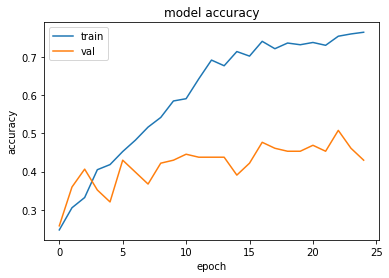

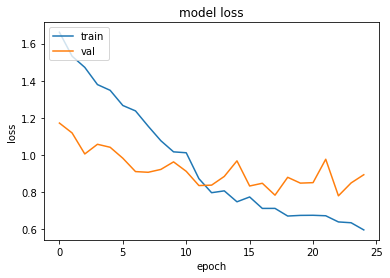

In [115]:
plot_loss_accuracy(history)

### Experiemt 10 CNN Transfer Learning (Mobilenet) + GRU

In [116]:
train_generator = generator(train_data_dir, train_folder_list, batch_size=10)
val_generator = generator(val_data_dir, val_folder_list, batch_size=10)

In [126]:
from tensorflow.keras.applications import MobileNet
from keras.layers import  MaxPooling2D
mobilenet_transfer = MobileNet(weights='imagenet', include_top=False)
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer, input_shape=(20, 120, 120, 3)))
model.add(Flatten())
model.add(Reshape((-1,1024)))
model.add(GRU(128))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 flatten_24 (Flatten)        (None, 184320)            0         
                                                                 
 reshape_8 (Reshape)         (None, 180, 1024)         0         
                                                                 
 gru_9 (GRU)                 (None, 128)               443136    
                                                                 
 dropout_61 (Dropout)        (None, 128)               0         
                                                                 
 dense_69 (Dense)            (None, 64)                8256      
                                                     

In [127]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [128]:
history = train_model('Model10', model, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size=10)

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.4359 - categorical_accuracy: 0.3567Source path =  /datasets/Project_data/val/ ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.07471, saving model to /home/models/Model10_2025-04-0122_48_39.199666/model-00001-1.43586-0.35672-1.07471-0.61000.h5
67/67 [==============================] - 28s 398ms/step - loss: 1.4359 - categorical_accuracy: 0.3567 - val_loss: 1.0747 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.9229 - categorical_accuracy: 0.6119
Epoch 00002: val_loss improved from 1.07471 to 0.79628, saving model to /home/models/Model10_2025-04-0122_48_39.199666/model-00002-0.92290-0.61194-0.79628-0.71000.h5
67/67 [==============================] - 26s 390ms/step - loss: 0.9229 - categorical_accuracy: 0.6119 - val_loss: 0.7963 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s -

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


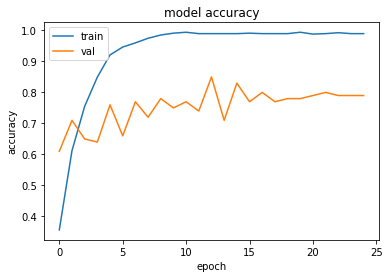

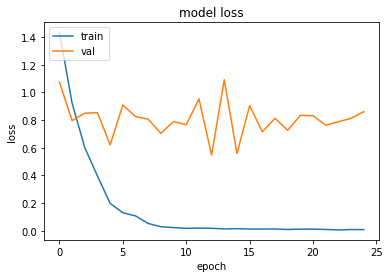

In [129]:
plot_loss_accuracy(history)